In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import h5py as h5

import os

In [209]:
# Read in the merged Chi squared / Proppant and Fluid placement results
merged_results = pd.read_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\results\merged_results.csv')
merged_results.describe()

,Unnamed: 0,Unnamed: 0.1,Channel Number,Optical Distance,Measured Depth (mKB),UTM - N,UTM - E,True Vertical Depth (mKB),Stage,Cluster,...,r2_Chi_std,r3_Chi_std,r4_Chi_std,Stage_separation_below,Clusters_per_m,Proppant_per_m,Proppant_per_cluster,Fluid_per_m,Fluid_per_cluster,Stage_separation_above
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,291.000000,291.000000,...,6497.000000,6497.000000,6497.000000,6495.000000,6500.000000,6.500000e+03,6500.000000,6500.000000,6500.000000,6495.000000
mean,3249.500000,3249.500000,-0.207538,3250.000000,3255.406077,91.378892,119.712108,3245.293077,28.484536,3.202749,...,8.096822,14.645773,3.181463,-1.430978,inf,inf,36628.550490,inf,1473.102585,1.436397
std,1876.532707,1876.532707,7.280343,1876.532707,1878.426061,99.084995,141.392695,1867.681699,16.791283,1.715083,...,28.867341,75.719254,10.275090,7.450830,NaN,NaN,49766.841343,NaN,8635.829777,7.472739
min,0.000000,0.000000,-1.000000,0.500000,3.400000,0.000000,-8.600000,3.400000,1.000000,1.000000,...,0.000000,0.000000,0.000000,-73.200000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1624.750000,1624.750000,-1.000000,1625.250000,1628.150000,2.000000,-6.300000,1628.050000,14.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,3249.500000,3249.500000,-1.000000,3250.000000,3258.900000,54.350000,59.150000,3254.100000,28.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,4874.250000,4874.250000,-1.000000,4874.750000,4882.850000,176.325000,236.825000,4863.350000,42.000000,4.000000,...,2.667892,3.648639,1.327224,0.000000,0.117096,1.165728e+04,99608.600000,233.569740,1953.583333,0.000000
max,6499.000000,6499.000000,100.000000,6499.500000,6507.000000,298.500000,425.500000,6471.600000,58.000000,10.000000,...,265.246158,877.618181,76.172171,0.000000,inf,inf,165679.666667,inf,101948.200000,73.200000


In [252]:
shape = merged_results.loc[pd.notnull(merged_results['Stage'])].shape[0]
merged_results.loc[pd.notnull(merged_results['Stage']) ,'Fluid%'] = ur['% Fluid'][:shape]
merged_results.loc[pd.notnull(merged_results['Stage']) ,'Proppant%'] = ur['% Proppant'][:shape]
merged_results.loc[pd.notnull(merged_results['Stage']) ,'Proppant(lbm)'] = ur['Prop (lbm)'][:shape]
merged_results.loc[pd.notnull(merged_results['Stage']) ,'Fluid%'] = ur['Fluid (bbl)'][:shape]

In [264]:
merged_results["Measured Depth (ftKB)"] = 3.28084 * merged_results['Measured Depth (mKB)']
merged_results["r0_ChiSum"] = 0
merged_results["r1_ChiSum"] = 0
merged_results["r2_ChiSum"] = 0
merged_results["r3_ChiSum"] = 0
merged_results["r4_ChiSum"] = 0
merged_results["r0_Chi_m"] = 0
merged_results["r1_Chi_m"] = 0
merged_results["r2_Chi_m"] = 0
merged_results["r3_Chi_m"] = 0
merged_results["r4_Chi_m"] = 0
merged_results["r0_Chi_std"] = 0
merged_results["r1_Chi_std"] = 0
merged_results["r2_Chi_std"] = 0
merged_results["r3_Chi_std"] = 0
merged_results["r4_Chi_std"] = 0

merged_results["Stage_separation_below_ft"] = 0
merged_results["Stage_separation_above_ft"] = 0
merged_results["Clusters_per_ft"] = 0
merged_results["Proppant_per_ft"] = 0
merged_results["Proppant_per_cluster"] = 0
merged_results["Fluid_per_ft"] = 0
merged_results["Fluid_per_cluster"] = 0

for stage, group in merged_results.groupby("Stage"):
    top_depth = group["Measured Depth (ftKB)"].min() -3.28084
    bottom_depth = group["Measured Depth (ftKB)"].max() + 3.28084
    
    for i in range(5):
        merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), 
                           "r{0}_ChiSum".format(i)] = merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), 
                                                                         "r{0}_ChiMean".format(i)].sum()
        
        merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), 
                           "r{0}_Chi_std".format(i)] = merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), 
                                                                         "r{0}_ChiMean".format(i)].std()
        
        merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), 
                           "r{0}_Chi_m".format(i)] = merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), 
                                                                         "r{0}_ChiMean".format(i)].sum() / (bottom_depth - top_depth)
        
    merged_results.loc[group.index, "Stage_separation_below"] = group["Measured Depth (ftKB)"] - merged_results.loc[merged_results["Stage"] == stage -1, "Measured Depth (ftKB)"].min()
    merged_results.loc[group.index, "Stage_separation_above"] = group["Measured Depth (ftKB)"] - merged_results.loc[merged_results["Stage"] == stage +1, "Measured Depth (ftKB)"].max()
    
    merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), "Clusters_per_ft"] = group['Clusters_per_stage'].mean() / (bottom_depth - top_depth)
    merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), "Proppant_per_ft"] = group['Proppant(lbm)'].sum() / (bottom_depth - top_depth)
    merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), "Proppant_per_cluster"] = group['Proppant(lbm)'].sum() / group['Clusters_per_stage'].mean()
    
    merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), "Fluid_per_ft"] = group['Fluid(bbl)'].sum() / (bottom_depth - top_depth)
    merged_results.loc[merged_results["Measured Depth (ftKB)"].between(top_depth, bottom_depth), "Fluid_per_cluster"] = group['Fluid(bbl)'].sum() / group['Clusters_per_stage'].mean()

In [246]:
ur = pd.read_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\results\FINAL Rice Iron Warrior 4H Final Fluid-Proppant Placement.csv')

In [253]:
merged_results.to_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\results\merged_results_ft.csv')

In [265]:
for i, group in ur.groupby('#Stage'):
    print(i, group['Fluid (bbl)'].max())

1 4365.7
2 2803.8
3 2234.8
4 1609.0
5 2176.4
6 2936.0
7 3491.0
8 3213.3
9 2373.2
10 3023.2
11 2766.6
12 2628.1
13 2523.7
14 2525.7
15 3273.7
16 3225.1
17 3872.6
18 2913.4
19 3745.4
20 3395.9
21 2775.2
22 5694.1
23 3464.0
24 3691.9
25 3513.4
26 3070.0
27 3536.3
28 5011.2
29 2188.1
30 3431.0
31 3224.0
32 3181.7
33 2479.2
34 2672.5
35 2958.8
36 3348.6
37 2707.7
38 2485.1
39 3590.1
40 3351.6
41 3158.2
42 3234.1
43 2705.2
44 2729.6
45 5396.3
46 3913.9
47 2656.9
48 2280.5
49 3810.3
50 3692.0
51 2664.4
52 2961.5
53 3189.1
54 2333.3
55 2352.7
56 2713.0
57 3167.5
58 3193.9


In [8]:
# Read the geothermal data from the cementing DTS set
cement_dir = r'C:\Users\george.crowther\Dropbox (OptaSense OFS)\Rice - OptaSense Project\Cement Data'
cement_files = [os.path.join(cement_dir, f) for f in os.listdir(cement_dir)]
geothermal = pd.read_csv(cement_files[0], skiprows=11)
geothermal.head()

,Distance (ft),Temp(F)
0,0.000,65.91
1,1.657,69.83
2,3.314,62.74
3,4.971,62.78
4,6.628,65.26


In [10]:
# Read the median filtered DAS data from the pickled files
input_dir = r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\data\med_filtered'
fdata_frames = [pd.read_pickle(os.path.join(input_dir, f)) for f in os.listdir(input_dir)]
fdata_frames[0].head()

,0,1,2,3,4,5,6,7,8,9,...,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015
2016-04-21 08:00:00,0.465461,0.463787,0.452576,0.435489,0.440829,0.438247,0.444870,0.450126,0.476946,0.488399,...,29.979033,33.156284,38.195530,36.144432,35.231590,35.110703,31.746790,34.198677,31.077599,33.846912
2016-04-21 09:00:00,0.466791,0.465416,0.465211,0.469138,0.478266,0.493523,0.512160,0.529613,0.540385,0.551081,...,34.494949,35.516106,35.009941,34.705170,35.669270,35.735962,35.497955,35.464272,35.170727,35.107063
2016-04-21 10:00:00,0.238934,0.248718,0.273100,0.301257,0.329441,0.376585,0.421341,0.475908,0.525576,0.563730,...,36.921417,36.899025,36.808178,36.607491,36.949375,37.193321,36.850346,36.829941,36.619530,36.671593
2016-04-21 11:00:00,0.481379,0.499752,0.512051,0.524172,0.539566,0.559841,0.583445,0.615443,0.664783,0.693591,...,36.298252,36.395782,36.686237,37.508598,37.628723,37.692551,37.679394,37.096272,37.350861,37.527031
2016-04-21 12:00:00,0.488677,0.486039,0.490423,0.508159,0.523741,0.543308,0.573556,0.607104,0.638269,0.672457,...,37.540413,37.011116,37.736023,37.727848,37.743618,37.538521,38.024147,37.567940,37.928955,37.457870


In [15]:
# Read the startup FBE data
startup_f = h5.File(r'C:\Users\george.crowther\Dropbox (OptaSense OFS)\Customer Projects\Rice Energy\Belmont Project\Flow_Project\Output\FBE_Export_2017-03-30_09_27_46_00\fbe_1.000s_2016-04-21T085949Z.h5', 'r')
startup = [startup_f['Acquisition/Processed/Fbe[1]/FbeData[{0}]'.format(n)] for n in range(5)]
startup_frame = pd.DataFrame(data = startup[0].value, index = pd.to_datetime(startup_f['Acquisition/Processed/Fbe[1]/FbeDataTime'].value * 1000))
startup_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015
2016-04-21 08:59:49,0.825994,0.823023,0.803128,0.772806,0.782282,0.777700,0.789453,0.798781,0.846375,0.866699,...,53.199924,58.838184,67.780685,64.140869,62.520962,62.306438,56.336937,60.687984,55.149410,60.063755
2016-04-21 09:00:19,0.851301,0.861825,0.851566,0.829139,0.832174,0.837888,0.835931,0.823507,0.833393,0.862101,...,59.675190,62.908386,62.266899,56.983643,51.418140,54.761402,59.270618,64.185089,62.235363,65.514252
2016-04-21 09:00:49,0.818652,0.800892,0.785124,0.797207,0.807135,0.822367,0.840565,0.852523,0.852058,0.866666,...,53.840302,57.295696,56.588421,58.615631,59.858616,61.182705,59.732883,55.266079,59.148144,61.173141
2016-04-21 09:01:19,0.812951,0.812471,0.797712,0.866977,0.875967,0.860597,0.859086,0.873796,0.868369,0.877859,...,56.261971,54.408009,53.995663,54.691628,53.022942,61.046154,67.440079,66.169975,66.624596,70.086044
2016-04-21 09:01:49,0.765309,0.751986,0.720801,0.773485,0.782948,0.763227,0.782275,0.829971,0.860044,0.891662,...,56.983231,71.861839,60.229858,58.340759,65.596992,68.399521,67.354164,62.194839,59.730526,59.981110


In [4]:
# Read the original results and place in dataframe
import_path = r'C:\Users\george.crowther\Dropbox (OptaSense OFS)\Customer Projects\Rice Energy\Belmont Project\Flow_Project\Output\Quantitative_Flow_Profiling_2017-02-21_10_47_34_00\curves.h5'
f = h5.File(import_path, 'r')
fdata = f['/Curves/Quantitative Output 2017-02-21 10:47:36+0000/Inflow at Perforation_Valve/Data']
fdatalabels_b = f['/Curves/Quantitative Output 2017-02-21 10:47:36+0000/Inflow at Perforation_Valve'].attrs['columnLabels']
fdatalabels = [x.decode() for x in fdatalabels_b]
stage_results = pd.DataFrame(data = fdata.value.T)
# Add stage and cluster information from merged_results dataframe
stage_results['Stage'] = merged_results.loc[pd.notnull(merged_results['Stage']), 'Stage'].values[:stage_results.shape[0]]
stage_results['Cluster'] = merged_results.loc[pd.notnull(merged_results['Stage']), 'Cluster'].values[:stage_results.shape[0]]
stage_results['Shots'] = merged_results.loc[pd.notnull(merged_results['Stage']), 'Shots'].values[:stage_results.shape[0]]
stage_results['Clusters_per_stage'] = merged_results.loc[pd.notnull(merged_results['Stage']), 'Clusters_per_stage'].values[:stage_results.shape[0]]
stage_results['Clusters_per_ft'] = merged_results.loc[pd.notnull(merged_results['Stage']), 'Clusters_per_ft'].values[:stage_results.shape[0]]
stage_results['Proppant_per_ft'] = merged_results.loc[pd.notnull(merged_results['Stage']), 'Proppant_per_ft'].values[:stage_results.shape[0]]
stage_results['Proppant_per_cluster'] = merged_results.loc[pd.notnull(merged_results['Stage']), 'Proppant_per_cluster'].values[:stage_results.shape[0]]
stage_results['Fluid_per_ft'] = merged_results.loc[pd.notnull(merged_results['Stage']), 'Fluid_per_ft'].values[:stage_results.shape[0]]
stage_results['Fluid_per_cluster'] = merged_results.loc[pd.notnull(merged_results['Stage']), 'Fluid_per_cluster'].values[:stage_results.shape[0]]

col = stage_results.columns.values
col[:212] = pd.to_datetime(f['/Curves/Quantitative Output 2017-02-21 10:47:36+0000/Timestamps/Data'].value.flatten() * 1000000)
stage_results.columns = col

stage_results.describe()

,1461229189000000000,1461239989000000000,1461250789000000000,1461261589000000000,1461272389000000000,1461283189000000000,1461293989000000000,1461304789000000000,1461315589000000000,1461326389000000000,...,1463507989000000000,Stage,Cluster,Shots,Clusters_per_stage,Clusters_per_ft,Proppant_per_ft,Proppant_per_cluster,Fluid_per_ft,Fluid_per_cluster
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,...,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,0.425917,0.387744,0.407410,0.429902,0.427752,0.439366,0.462626,0.447623,0.762526,0.870076,...,0.456197,29.444840,3.209964,5.740214,5.419929,0.038971,3794.209110,98981.608541,135.711949,3803.763701
std,0.190518,0.186803,0.191977,0.200091,0.199702,0.208366,0.200007,0.198862,0.200908,0.227503,...,0.220701,16.281167,1.724417,1.035160,1.342237,0.014774,1594.776273,21363.454303,421.159734,13241.615830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267034,0.328069,...,0.000000,3.000000,1.000000,3.000000,1.000000,0.024714,0.000000,0.000000,0.000000,0.000000
25%,0.317909,0.287398,0.297463,0.320101,0.330265,0.322106,0.352960,0.333098,0.632832,0.722712,...,0.324817,16.000000,2.000000,6.000000,5.000000,0.034094,3390.077201,98548.000000,67.761878,1931.020000
50%,0.443839,0.405496,0.417036,0.436604,0.442484,0.470715,0.480398,0.457047,0.783711,0.892842,...,0.491734,29.000000,3.000000,6.000000,5.000000,0.035524,3547.434251,99890.800000,72.129304,1991.220000
75%,0.546217,0.519884,0.539702,0.555818,0.561833,0.570704,0.582095,0.572500,0.901525,1.021062,...,0.600374,43.000000,4.000000,6.000000,5.000000,0.037353,3722.128271,100136.000000,79.124463,2166.040000
max,0.888758,0.803520,0.946917,1.070760,0.903118,1.403189,1.592185,1.097483,1.849026,2.119457,...,1.280270,58.000000,10.000000,10.000000,10.000000,0.152400,15382.493508,165679.666667,3236.855246,101948.200000


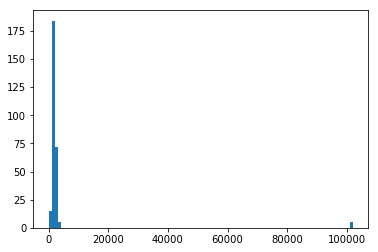

In [244]:
fig, ax = plt.subplots()

val, bins, n = ax.hist(stage_results['Fluid_per_cluster'], bins = 100)

plt.show()

In [240]:
val

array([   5.,    0.,    0.,    0.,  228.,   32.,   10.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    3.,    0.,    0.,
          0.,    3.])

In [60]:
vfile = h5.File(r'C:\Users\george.crowther\Dropbox (OptaSense OFS)\Customer Projects\Rice Energy\Belmont Project\Flow_Project\Output\Graphical_Features_Tracking_Tool_2017-04-05_15_17_27_00\curves.h5', 'r')
channel_depths = vfile['/Curves/Graphical Feature Tracker Output 2017-04-05 15:17:27+0100/Channel Depths/Data']
channel_times = vfile['/Curves/Graphical Feature Tracker Output 2017-04-05 15:17:27+0100/Timestamps/Data']

In [158]:
% matplotlib inline

In [168]:
dt = (ctimes[1, :] - ctimes[0, :]) / 1e3
ds = cdepths[0, :] - cdepths[1, :]

v = ds/dt

vdepths = []

desired_time = ctimes[0, :].max()

for i, t in enumerate(ctimes[0, :]):
    
    new_depth = ((desired_time - t )/1e3) * -1*v[i] + cdepths[0, i]
    vdepths.append(new_depth)

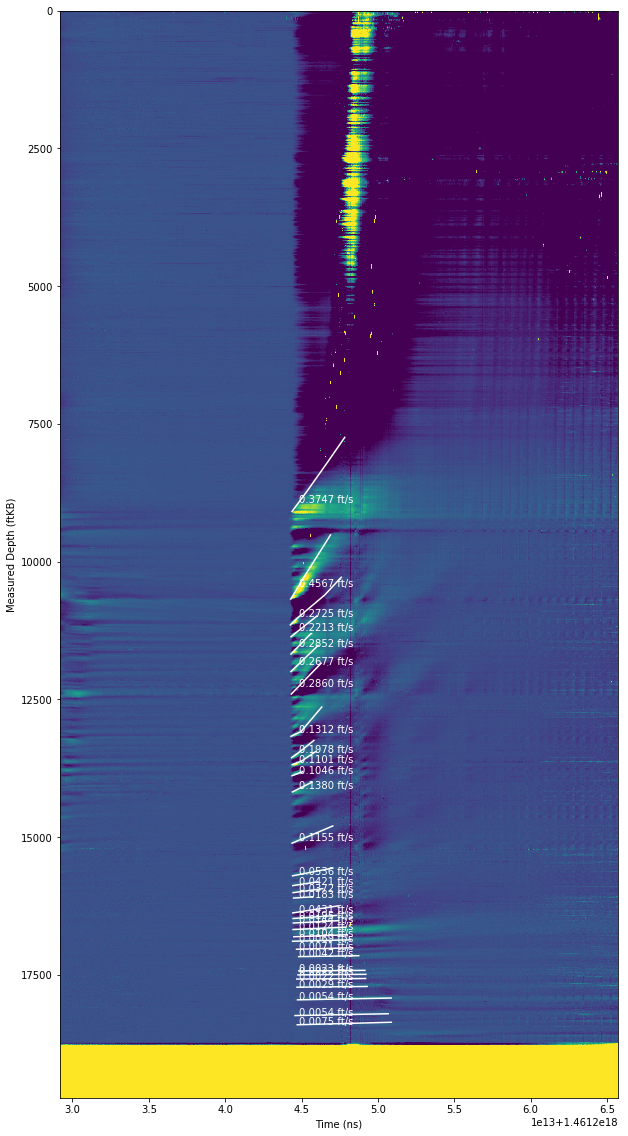

In [189]:
fig, ax = plt.subplots(figsize = (10, 20))
ax.imshow(10*np.log10(startup_frame).T, aspect = 'auto', 
          extent = (startup_frame.index[0].value, startup_frame.index[-1].value,
                    startup_frame.columns[-1] * 3.28084, startup_frame.columns[0] * 3.28084),
         vmin = -1, vmax = 3)

cdepths = channel_depths.value
cdepths[cdepths == 0.0] = np.nan
ctimes = channel_times.value
ctimes[ctimes == 0.0] = np.nan

for i in range(ctimes.shape[1]):
    ax.plot(ctimes[:, i] * 1e+6, cdepths[:, i], color = 'white')
    
for i, d in enumerate(vdepths):
    ax.text(ctimes[0, :].max() * 1e6, d, "{0:.4f} ft/s".format(v[i]), color = 'white')

ax.set_ylabel("Measured Depth (ftKB)")
ax.set_xlabel("Time (ns)")
    
plt.show()

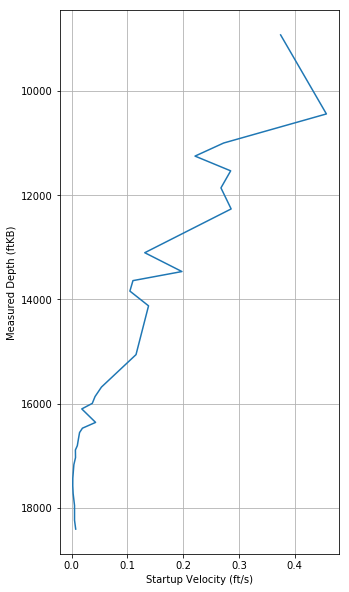

In [170]:
fig, ax = plt.subplots(figsize = (5, 10))
ax.plot(v, vdepths)
ax.invert_yaxis()
ax.grid()
ax.set_ylabel("Measured Depth (ftKB)")
ax.set_xlabel("Startup Velocity (ft/s)")
plt.show()

In [274]:
stage_results['Proppant_per_ft']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
       ..
251   NaN
252   NaN
253   NaN
254   NaN
255   NaN
256   NaN
257   NaN
258   NaN
259   NaN
260   NaN
261   NaN
262   NaN
263   NaN
264   NaN
265   NaN
266   NaN
267   NaN
268   NaN
269   NaN
270   NaN
271   NaN
272   NaN
273   NaN
274   NaN
275   NaN
276   NaN
277   NaN
278   NaN
279   NaN
280   NaN
Name: Proppant_per_ft, dtype: float64

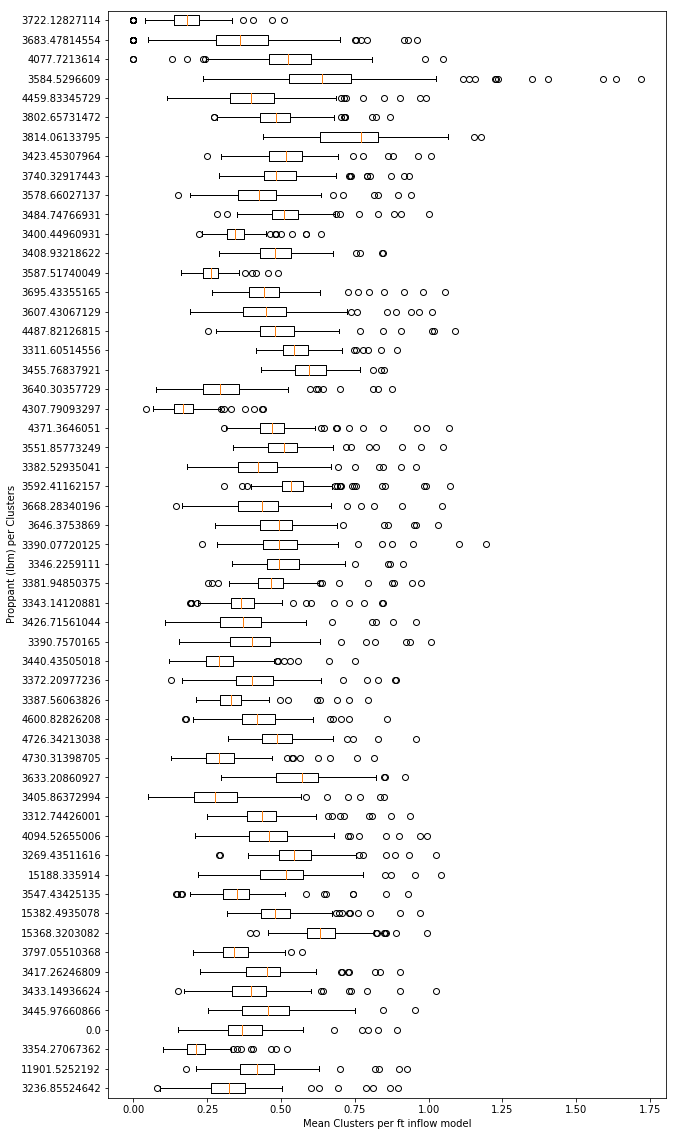

In [5]:
data = []
agg = 'Proppant_per_ft'

fig, ax = plt.subplots(figsize = (10, 20))
for stage, group in stage_results.groupby(agg):
    data.append(group.iloc[:, :212].mean())
    
dset = np.vstack(data)
ax.boxplot(dset.T, vert = False, labels = [str(n) for n in stage_results[agg].unique()])
    
ax.set_ylabel("Proppant (lbm) per Clusters")
ax.set_xlabel("Mean Clusters per ft inflow model")
    
plt.show()

In [273]:
for stage, group in stage_results.groupby(agg):
    #data.append(group.iloc[:, :212].mean())
    print(stage)

In [2]:
merged_results = pd.read_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\results\merged_results_ft.csv')

In [6]:
stage_results.columns

Index([   1461229189000000000,    1461239989000000000,    1461250789000000000,
          1461261589000000000,    1461272389000000000,    1461283189000000000,
          1461293989000000000,    1461304789000000000,    1461315589000000000,
          1461326389000000000,
       ...
          1463507989000000000,                'Stage',              'Cluster',
                      'Shots',   'Clusters_per_stage',      'Clusters_per_ft',
            'Proppant_per_ft', 'Proppant_per_cluster',         'Fluid_per_ft',
          'Fluid_per_cluster'],
      dtype='object', length=221)

In [33]:
surface_frame = pd.read_csv(r'C:\Users\george.crowther\Dropbox (OptaSense OFS)\Customer Projects\Rice Energy\Belmont Project\Flow_Project\User\IW4H Raw Hourly.csv')
surface_frame.index = pd.to_datetime(surface_frame['Date & Time'])

In [42]:
surface_frame.sort_index(inplace = True)
surface_frame['Daily Gas Rate'] = pd.to_numeric(surface_frame['Daily Gas Rate'])

In [44]:
import datetime

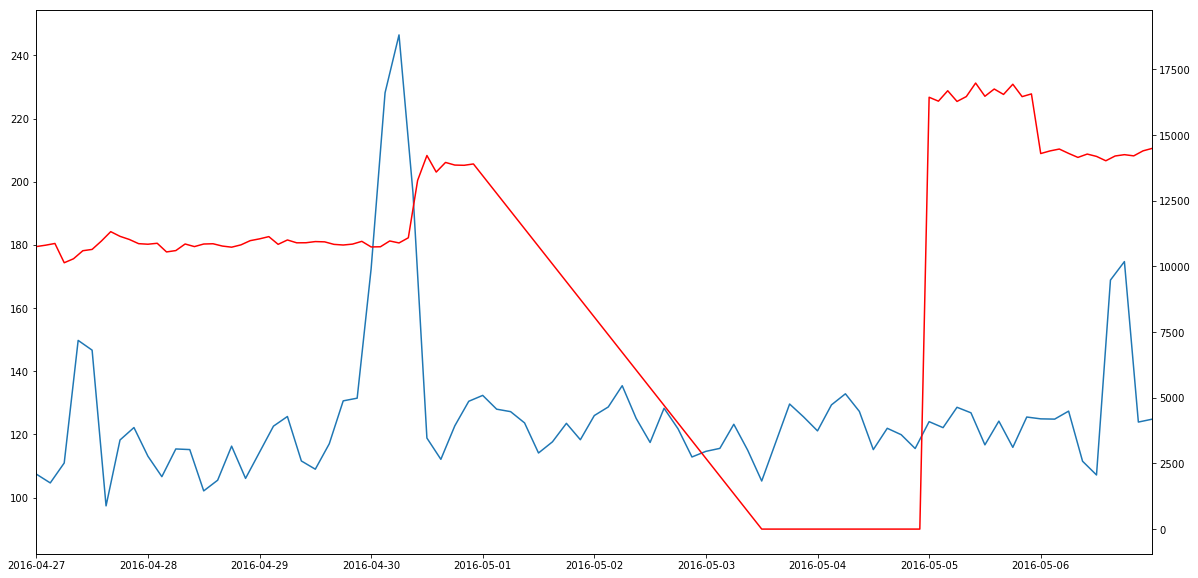

In [102]:
x = [datetime.date(2016, 5, 6), datetime.date(2016, 5, 18)]

fig, ax = plt.subplots(figsize = (20, 10))

ax.plot(pd.to_datetime(stage_results.columns[:212].values), stage_results.loc[:, stage_results.columns[:212]].sum(axis=0))
ax2 = ax.twinx()

plot_frame = surface_frame['April 2016': 'June 2016'].resample('2H').mean().interpolate(how='time')
ax2.plot(plot_frame.index, plot_frame['Daily Gas Rate'], color = 'red')
ax.xaxis_date()
ax.set_xlim((pd.to_datetime(interval_1[-1]), pd.to_datetime(interval_2[-1])))
plt.show()

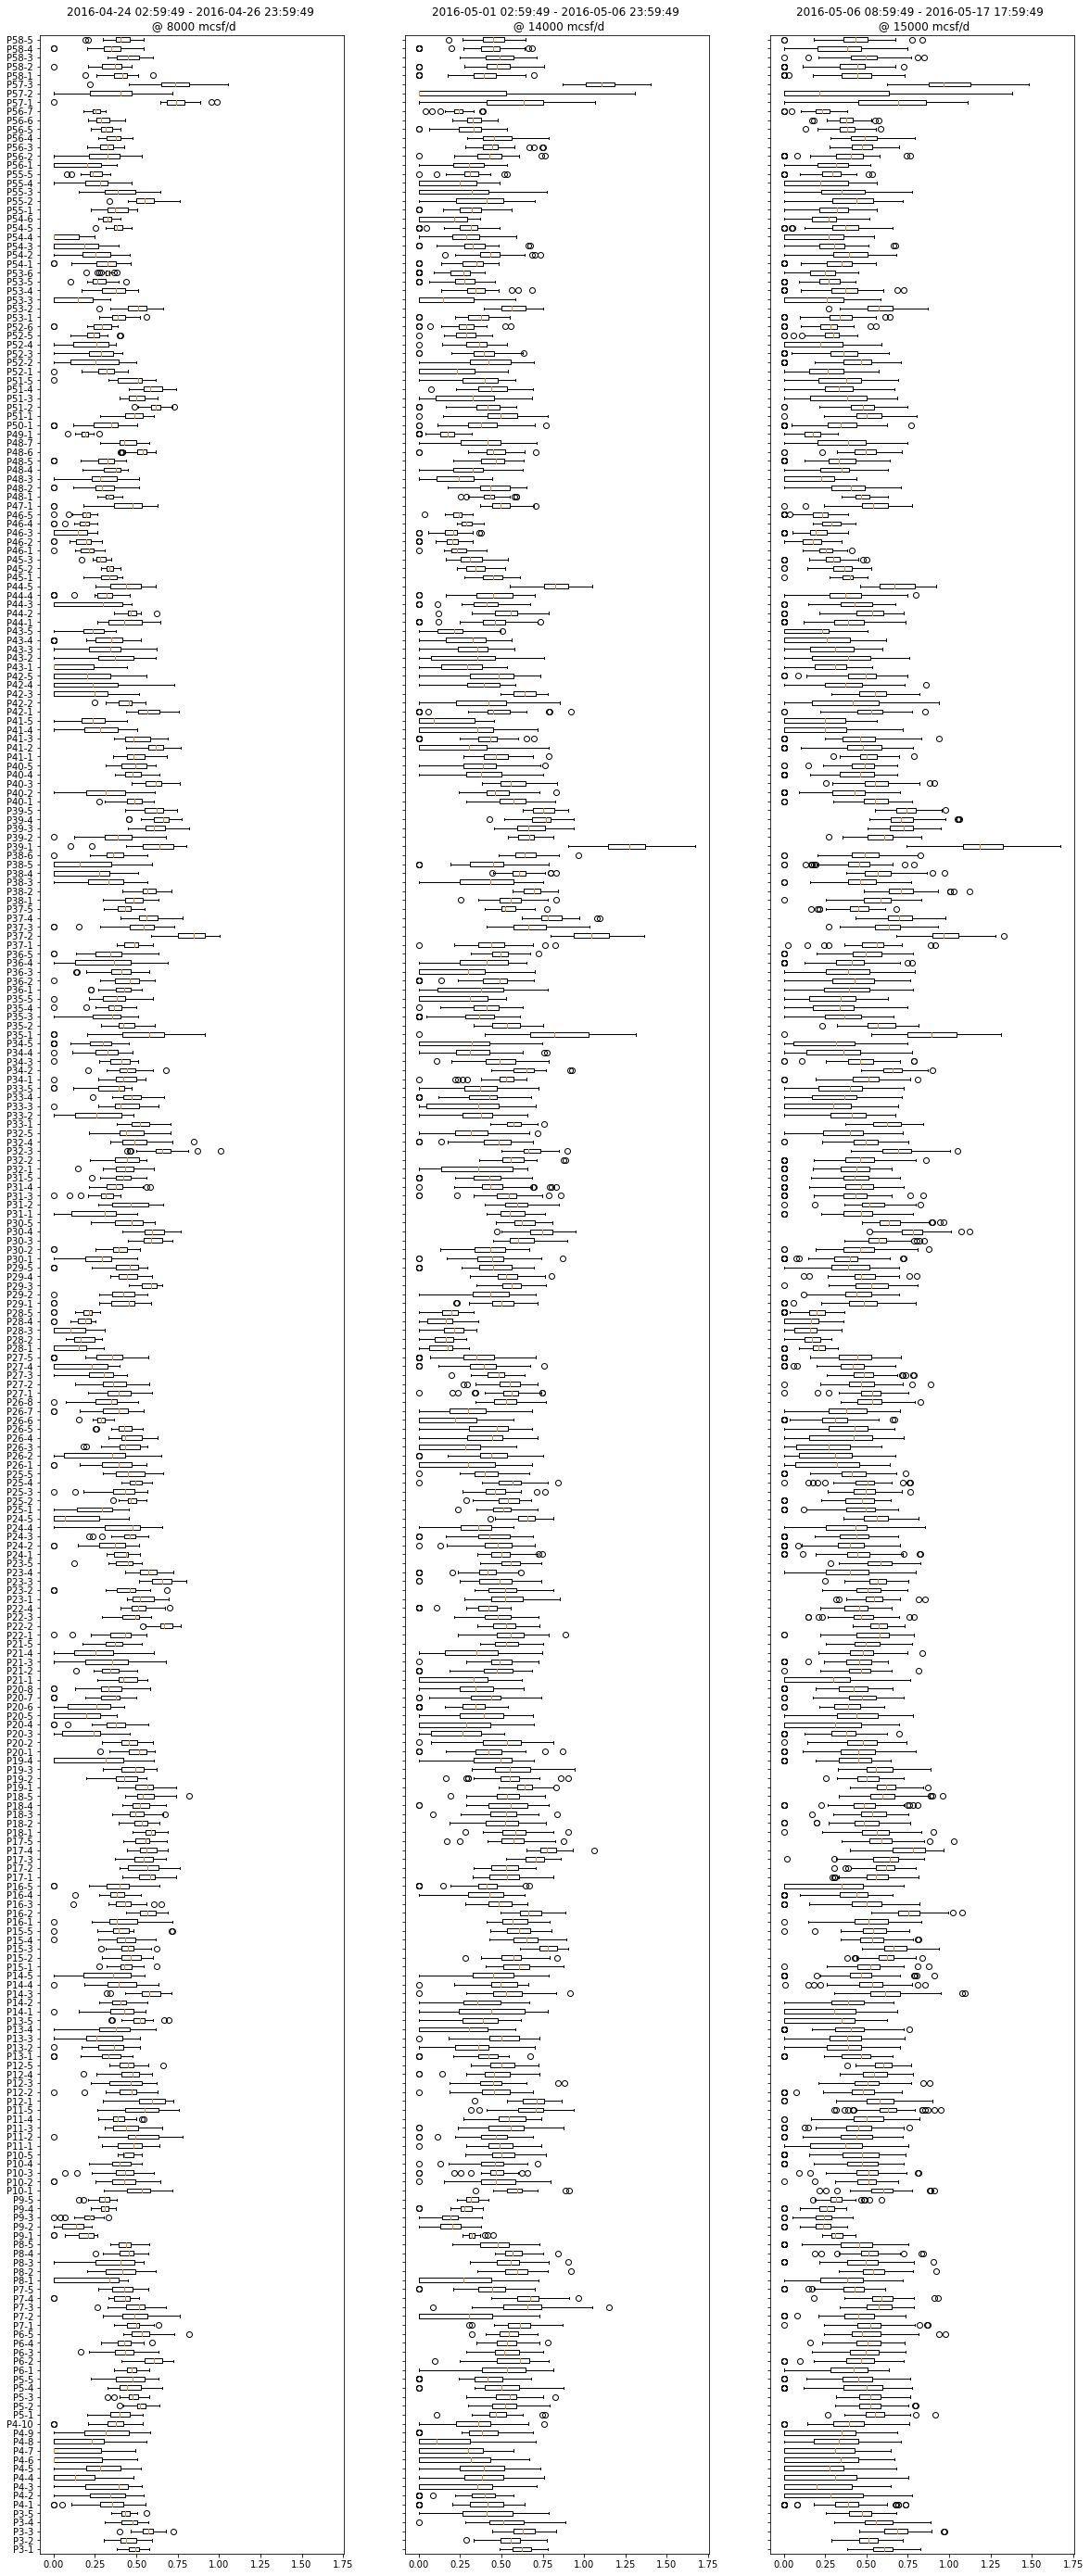

In [107]:
fig, ax = plt.subplots(1, 3, figsize = (20, 50), sharey = True, sharex = True)
ax[0].boxplot(stage_results.loc[:, interval_1].as_matrix().T, vert = False, 
           labels = ['P{0}-{1}'.format(int(i), int(j)) for i, j in zip(stage_results['Stage'], stage_results['Cluster'])])
ax[0].set_title("{0} - {1} \n @ 8000 mcsf/d".format(pd.to_datetime(interval_1[0]), pd.to_datetime(interval_1[-1])))
ax[1].boxplot(stage_results.loc[:, interval_2].as_matrix().T, vert = False, 
           labels = ['P{0}-{1}'.format(int(i), int(j)) for i, j in zip(stage_results['Stage'], stage_results['Cluster'])])
ax[1].set_title("{0} - {1} \n @ 14000 mcsf/d".format(pd.to_datetime(interval_2[0]), pd.to_datetime(interval_2[-1])))

ax[2].boxplot(stage_results.loc[:, interval_3].as_matrix().T, vert = False, 
           labels = ['P{0}-{1}'.format(int(i), int(j)) for i, j in zip(stage_results['Stage'], stage_results['Cluster'])])
ax[2].set_title("{0} - {1} \n @ 15000 mcsf/d".format(pd.to_datetime(interval_3[0]), pd.to_datetime(interval_3[-1])))

ax[0].invert_yaxis()
plt.show()

In [109]:
stage_results.columns

Index([   1461229189000000000,    1461239989000000000,    1461250789000000000,
          1461261589000000000,    1461272389000000000,    1461283189000000000,
          1461293989000000000,    1461304789000000000,    1461315589000000000,
          1461326389000000000,
       ...
          1463507989000000000,                'Stage',              'Cluster',
                      'Shots',   'Clusters_per_stage',      'Clusters_per_ft',
            'Proppant_per_ft', 'Proppant_per_cluster',         'Fluid_per_ft',
          'Fluid_per_cluster'],
      dtype='object', length=221)

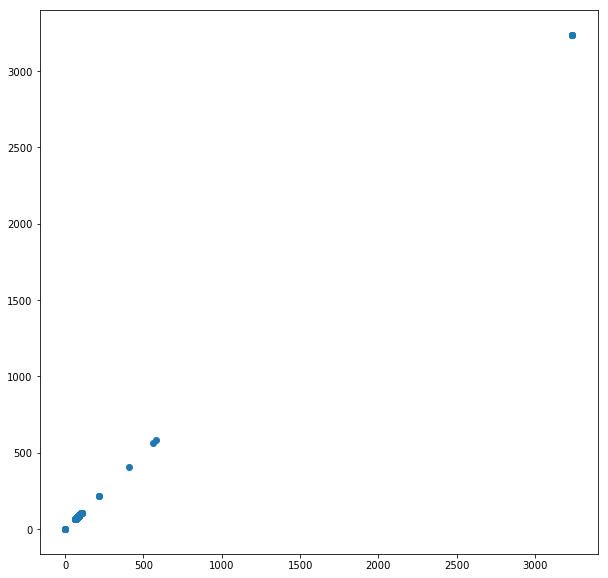

In [113]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(stage_results['Fluid_per_ft'], stage_results['Fluid_per_ft'])
plt.show()

In [125]:
from sklearn.cluster import KMeans

In [142]:
km = KMeans()
c = km.fit_predict(stage_results['Proppant_per_ft'].as_matrix().reshape(-1, 1))

In [146]:
stage_results.columns
cols = ['Clusters_per_ft', 'Proppant_per_ft', 'Proppant_per_cluster', 'Fluid_per_ft', 'Fluid_per_cluster']

for col in cols:
    km = KMeans()
    c = km.fit_predict(stage_results[col].as_matrix().reshape(-1, 1))
    stage_results['OHE {0}'.format(col)] = c

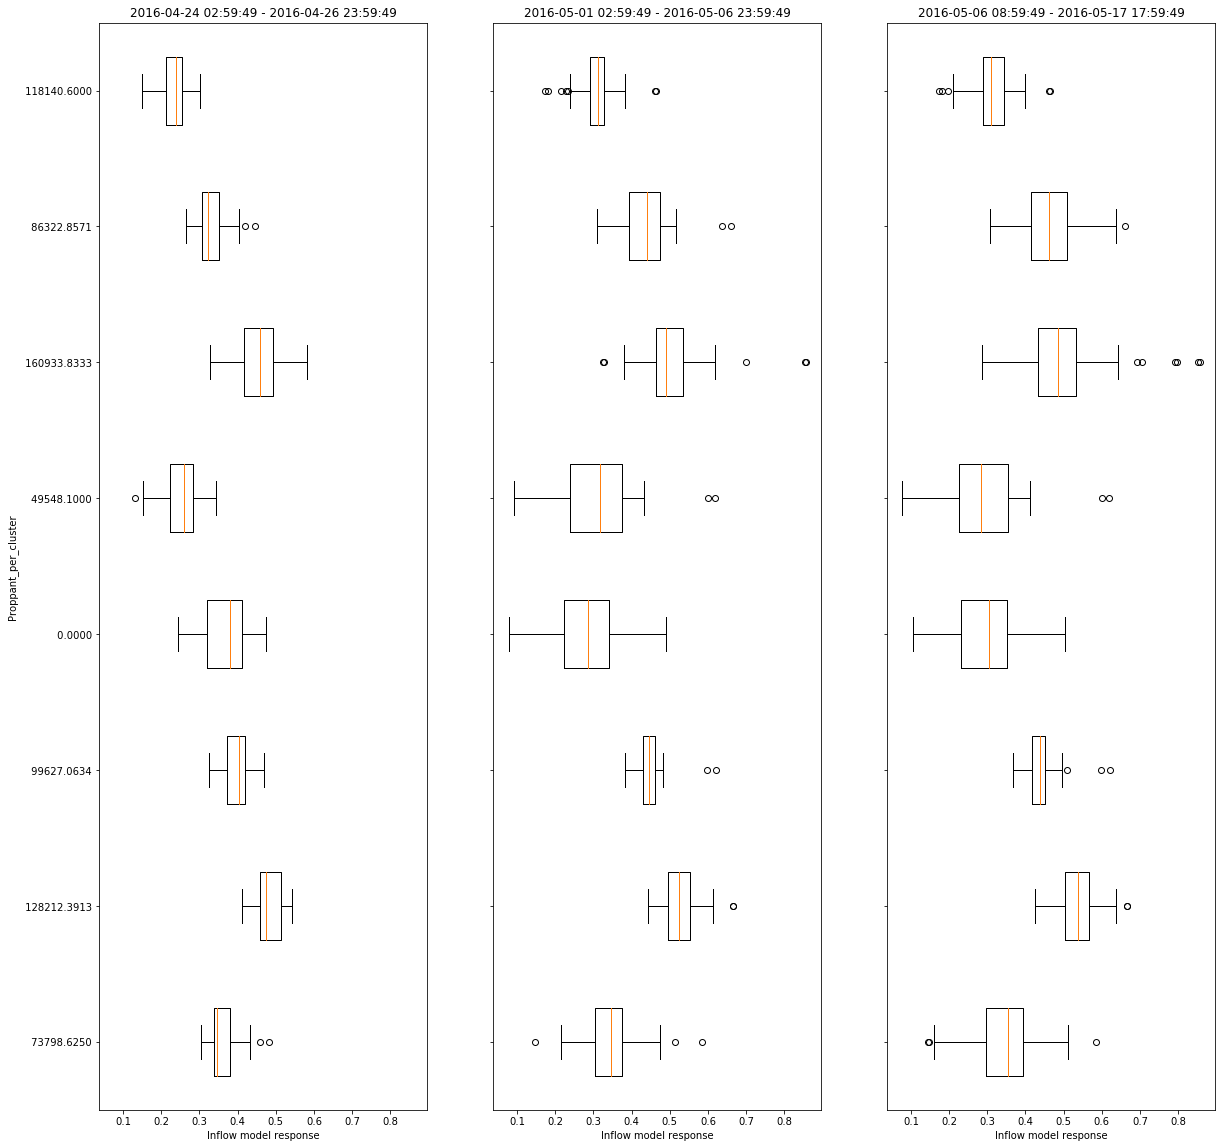

In [175]:
data = []
labels = []
agg = 'OHE Proppant_per_cluster'

fig, ax = plt.subplots(1, 3, figsize = (20, 20), sharex = True, sharey = True)
for i, interval in enumerate([interval_1, interval_2, interval_3]):
    data = []
    labels = []
    for stage, group in stage_results.groupby(agg):
        data.append(group.loc[:, interval].mean())
        labels.append("{0: .4f}".format(group[agg[4:]].mean()))
    
    dset = np.vstack(data)
    ax[i].boxplot(dset.T, vert = False, labels = labels)
    ax[i].set_xlabel("Inflow model response")
    ax[i].set_title("{0} - {1}".format(pd.to_datetime(interval[0]), pd.to_datetime(interval[-1])))
ax[0].set_ylabel(agg[4:])
    
plt.show()

In [163]:
stage_results.loc[stage_results['Clusters_per_ft'] == 0.0, ['Stage', 'Cluster']]

,Stage,Cluster


In [177]:
stage_results.to_csv(r'c:\users\george.crowther\documents\python\projects\rice_energy\results\stage_results.csv')